# Sprint1課題 機械学習フロー   

**この課題の目的**   
- 機械学習の実践的な流れを知る
- 高い汎化性能を持つモデルを完成させる

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**機械学習フロー**   
1回目のSprintでは、機械学習の実践的な流れを抑えます。このSprintはWeek3,4の延長になり、引き続きKaggleの Home Credit Default Risk コンペティションを用います。特にここでは適切な検証を組み込むことを重視し、その上で前処理やモデルの選定を進めていきます。

適切な検証を行い、テストデータに対して高い汎化性能を持つモデルを完成させましょう。

## 【問題1】 クロスバリデーション

事前学習期間は検証用データを分割しておき、それに対して指標値を計算することで検証を行っていました。しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション を行います。

具体的には分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割を行う関数はscikit-learnにKFoldとして用意されています。

[sklearn.model_selection.KFold — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import lightgbm as lgb

#DataFrameで表示できる行列の最大数を設定
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 100)

In [2]:
#データの読み込み
df = pd.read_csv('drive/My Drive/Sprint1/application_train.csv')
df_test = pd.read_csv('drive/My Drive/Sprint1/application_test.csv')
sk_id = df_test['SK_ID_CURR']
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [3]:
#object型のみ抽出
df_object_list = df.select_dtypes(include=object).columns

#one-hot encoding
df_onehot = pd.get_dummies(df[df_object_list])

#結合
df = pd.concat([df, df_onehot], axis=1)

#one_hot encodingする前の特徴量を削除
df.drop(columns=df_object_list, inplace=True)
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business

In [4]:
#重要度の算出
lgb = lgb.LGBMClassifier()

#特徴量の名前
feat_labels = df.columns[2:]

#説明変数と目的変数をndarrayに格納
X_features = df.iloc[:, 2:].values
y_features = df['TARGET'].values

#モデルを適合
lgb.fit(X_features, y_features)

#重要度の算出
importances = lgb.feature_importances_

##重要度の降順で特徴量インデックスを抽出
indices = np.argsort(importances)[::-1]

#出力
print('Feature Importances:')
for i in (range(40)):
    print('\t{0:20s} : {1:>.6f}'.format(feat_labels[indices[i]], importances[indices[i]]))

Feature Importances:
	EXT_SOURCE_1         : 265.000000
	EXT_SOURCE_3         : 226.000000
	EXT_SOURCE_2         : 200.000000
	DAYS_BIRTH           : 191.000000
	AMT_CREDIT           : 157.000000
	AMT_ANNUITY          : 143.000000
	AMT_GOODS_PRICE      : 140.000000
	DAYS_EMPLOYED        : 96.000000
	DAYS_ID_PUBLISH      : 95.000000
	OWN_CAR_AGE          : 85.000000
	DAYS_LAST_PHONE_CHANGE : 79.000000
	DAYS_REGISTRATION    : 73.000000
	AMT_INCOME_TOTAL     : 53.000000
	REGION_POPULATION_RELATIVE : 46.000000
	AMT_REQ_CREDIT_BUREAU_YEAR : 39.000000
	CODE_GENDER_F        : 34.000000
	NAME_EDUCATION_TYPE_Higher education : 30.000000
	NAME_CONTRACT_TYPE_Cash loans : 29.000000
	NAME_FAMILY_STATUS_Married : 29.000000
	AMT_REQ_CREDIT_BUREAU_QRT : 27.000000
	HOUR_APPR_PROCESS_START : 25.000000
	REGION_RATING_CLIENT_W_CITY : 24.000000
	DEF_30_CNT_SOCIAL_CIRCLE : 24.000000
	LANDAREA_MODE        : 24.000000
	YEARS_BEGINEXPLUATATION_MODE : 21.000000
	TOTALAREA_MODE       : 20.000000
	LANDAREA_AVG   

重要度を参考に、特徴量を絞り込む。

In [5]:
#データの絞り込み
df_list = ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'AMT_CREDIT', 
               'AMT_ANNUITY', 'AMT_INCOME_TOTAL']
df = df[df_list]
df.head()

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,AMT_INCOME_TOTAL
0,1,0.083037,0.262949,0.139376,-9461,406597.5,24700.5,202500.0
1,0,0.311267,0.622246,NaN,-16765,1293502.5,35698.5,270000.0
2,0,NaN,0.555912,0.729567,-19046,135000.0,6750.0,67500.0
3,0,NaN,0.650442,NaN,-19005,312682.5,29686.5,135000.0
4,0,NaN,0.322738,NaN,-19932,513000.0,21865.5,121500.0


In [6]:
#欠損値を平均で埋める
df['EXT_SOURCE_1'].fillna(df['EXT_SOURCE_1'].mean(), inplace=True)
df['EXT_SOURCE_2'].fillna(df['EXT_SOURCE_2'].mean(), inplace=True)
df['EXT_SOURCE_3'].fillna(df['EXT_SOURCE_3'].mean(), inplace=True)
df['AMT_ANNUITY'].fillna(df['AMT_ANNUITY'].mean(), inplace=True)
df.head()

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,AMT_INCOME_TOTAL
0,1,0.083037,0.262949,0.139376,-9461,406597.5,24700.5,202500.0
1,0,0.311267,0.622246,0.510853,-16765,1293502.5,35698.5,270000.0
2,0,0.502130,0.555912,0.729567,-19046,135000.0,6750.0,67500.0
3,0,0.502130,0.650442,0.510853,-19005,312682.5,29686.5,135000.0
4,0,0.502130,0.322738,0.510853,-19932,513000.0,21865.5,121500.0


In [0]:
#データをndrrayに格納
X = df.iloc[:, 1:].values
y = df['TARGET'].values

#データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [0]:
def pipeline(X_train, X_test, y_train, cls):
    '''
    モデルの学習から推測するまでの関数
    Parameters
    ----------------
    X_train : {array-like, sparse matrix}, shape (n_samples, n_features)
        学習用データ
    X_test : array_like or sparse matrix, shape (n_samples, n_features)
        検証用データ
    y_train : array-like, shape (n_samples,)
        学習用ラベル
    cls : class
        学習モデル
    
    Returns
    -----------
    y_pred : array-like, shape = [n_samples,]
        TARGETが1のときの確率
    '''
    #パイプラインの作成
    pipe_cls = make_pipeline(StandardScaler(), 
                                            PCA(n_components=3),
                                            cls)
    
    #学習
    pipe_cls.fit(X_train, y_train)
    
    #推測
    y_pred = pipe_cls.predict_proba(X_test)[:, 1]

    return y_pred

In [0]:
def auc_score(y_test, y_pred):
    '''
    AUCスコアとROC曲線を出力する関数
    Parameters
    ----------------
    y_test :  array_like or sparse matrix, shape (n_samples,)
        検証用ラベル
    y_pred : array-like, shape = [n_samples,]
        あるターゲットの確率
    '''
    #aucを計算
    auc = roc_auc_score(y_test, y_pred)

    #ある閾値の時のFPR、TPRを取得
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    #ROC曲線を作成
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    
    #AUCを出力
    print('AUC :', auc)

AUC : 0.6844906347373447


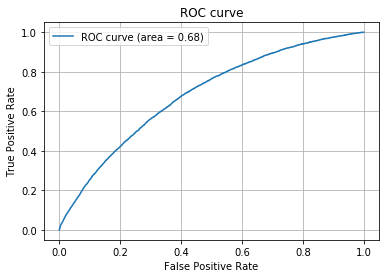

In [10]:
#ロジスティック回帰で予測
lr_pred= pipeline(X_train, X_test, y_train, LogisticRegression(solver='lbfgs'))
auc_score(y_test, lr_pred)

AUC : 0.5202613271255202


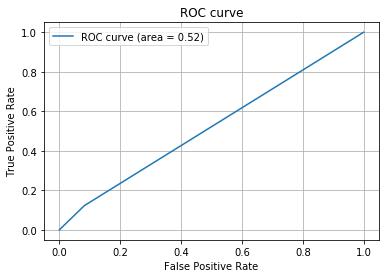

In [11]:
#決定木で実行
tree_pred = pipeline(X_train, X_test, y_train, DecisionTreeClassifier())
auc_score(y_test, tree_pred)

In [12]:
#クロスバリデーション(StratifiedKFold)
skf = StratifiedKFold(n_splits=5)
skf_split = skf.split(X, y)
lr = LogisticRegression(solver='lbfgs')

#scoreのリスト
scores = []

#n_splitの回数だけ行う
for k, (train, test) in enumerate(skf_split):
    
    #pipeline関数で推定まで行う
    y_pred = pipeline(X[train], X[test], y[train], lr)
    
    #AUCを算出し、リストに格納
    auc = roc_auc_score(y[test], y_pred)
    scores.append(auc)
    
    #出力
    print('Fold : {}, AUC : {}'.format(k+1, auc))

#平均と標準偏差も出力
print('AUCの平均 +/- h標準偏差: {:.3f} +/- {:.3f}'.format(np.mean(scores), np.std(scores)))

Fold : 1, AUC : 0.7167309979150456
Fold : 2, AUC : 0.6837187870499692
Fold : 3, AUC : 0.6818107244903974
Fold : 4, AUC : 0.6813902991563724
Fold : 5, AUC : 0.6882077081267227
AUCの平均 +/- h標準偏差: 0.690 +/- 0.013


In [13]:
#クロスバリデーション(KFold)
kf = KFold(n_splits=5)
kf_split = kf.split(X, y)
lr = LogisticRegression(solver='lbfgs')

#scoreのリスト
scores = []

#n_splitの回数だけ行う
for k, (train, test) in enumerate(kf_split):
    
    #pipeline関数で推定まで行う
    y_pred = pipeline(X[train], X[test], y[train], lr)
    
    #AUCを算出し、リストに格納
    auc = roc_auc_score(y[test], y_pred)
    scores.append(auc)
    
    #出力
    print('Fold : {}, AUC : {}'.format(k+1, auc))

#平均と標準偏差も出力
print('AUCの平均 +/- h標準偏差: {:.3f} +/- {:.3f}'.format(np.mean(scores), np.std(scores)))

Fold : 1, AUC : 0.7169722878204429
Fold : 2, AUC : 0.6842183658300618
Fold : 3, AUC : 0.6804586696928487
Fold : 4, AUC : 0.6818741171913821
Fold : 5, AUC : 0.6884740063941025
AUCの平均 +/- h標準偏差: 0.690 +/- 0.014


今回はStratifiedKFoldとKFoldにあまり大きな差は見られなかった。

## 【問題2】 グリッドサーチ

これまで分類器のパラメータは基本的にデフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになりますが、パラメータは状況に応じて最適なものを選ぶ必要があります。パラメータを探索するために グリッドサーチ と呼ばれる総当たり的手法が一般的に利用されます。

グリッドサーチをパイプラインの中に組み込みましょう。

In [0]:
def gridserch(X_train, X_test, y_train, y_test, param_grid, cls):
    '''
    グリッドサーチを行う関数
    Parameters
    ----------------
    X_train : {array-like, sparse matrix}, shape (n_samples, n_features)
        学習用データ
    X_test : array_like or sparse matrix, shape (n_samples, n_features)
        検証用データ
    y_train : array-like, shape (n_samples,)
        学習用ラベル
    y_test : array-like, shape (n_samples,)
        検証用ラベル
    param_grid : dict or list of dictionaries
        検証パラメータ
    cls : class
        学習モデル
    '''
    #パイプラインの作成
    pipe_cls = make_pipeline(StandardScaler(), cls)

    #グリッドサーチ
    cls_gs = GridSearchCV(estimator=pipe_cls,
                                      param_grid=param_grid,
                                      scoring='roc_auc', 
                                      cv=5)

    #fit
    cls_gs.fit(X_train, y_train)

    #結果の出力
    print('Test set score: {}'.format(cls_gs.score(X_test, y_test)))
    print('Best parameters: {}'.format(cls_gs.best_params_))
    print('Best cross-validation: {}'.format(cls_gs.best_score_))

In [15]:
#ロジスティック回帰でグリッドサーチ
#検証パラメータ
lr_param_grid = {'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
gridserch(X_train, X_test, y_train, y_test, lr_param_grid, LogisticRegression(solver='lbfgs'))

Test set score: 0.7244484297785457
Best parameters: {'logisticregression__C': 0.001}
Best cross-validation: 0.7193523774941345


AUC : 0.6845212686212734


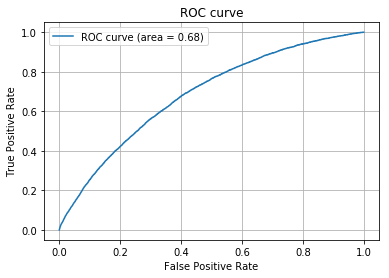

In [16]:
#ロジスティック回帰
lr_gs_pred = pipeline(X_train, X_test, y_train, LogisticRegression(solver='lbfgs', C=0.001))
auc_score(y_test, lr_gs_pred)

In [17]:
#決定木でグリッドサーチ
#検証パラメータ
tree_param_grid = {'decisiontreeclassifier__max_depth': list(range(4, 10))}
gridserch(X_train, X_test, y_train, y_test, tree_param_grid, DecisionTreeClassifier())

Test set score: 0.7148708587080712
Best parameters: {'decisiontreeclassifier__max_depth': 7}
Best cross-validation: 0.7142158546750523


AUC : 0.6840218711444245


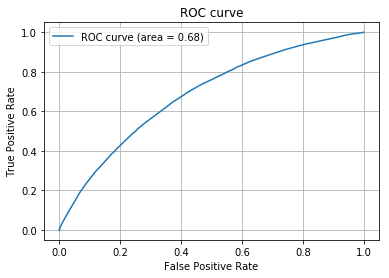

In [18]:
#決定木
tree_gs_pred = pipeline(X_train, X_test, y_train, DecisionTreeClassifier(max_depth=7))
auc_score(y_test, tree_gs_pred)

## 【問題3】 Kernelからの調査

KaggleのKernelから自身にはなかったアイデアを見つけ出して、列挙してください。そして、効果があると考えられるものを検証してください。

##  【問題4】 高い汎化性能のモデル

これまで学んだことを用いながら汎化性能の高いモデルを作成してください。今は全体の流れを掴むことを重視し、Sprintの時間内に結果を出すということも意識しましょう。

### ・ 学習モデルをLightgbmにする。

AUC : 0.6869313646320573


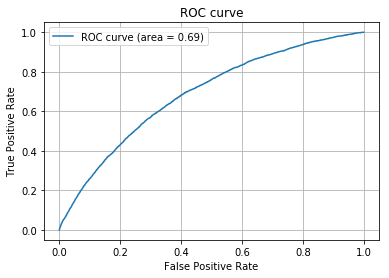

In [19]:
import lightgbm as lgb
#Lightgbmで実行
lgb_pred= pipeline(X_train, X_test, y_train, lgb.LGBMClassifier())
auc_score(y_test, lgb_pred)

In [20]:
#Lightgbmのグリッドサーチ
#検証パラメータ
num_leaves = list(range(20 , 41, 5))
min_data_in_leaf = list(range(15, 31, 3))
lgb_param_grid = {'lgbmclassifier__num_leaves': num_leaves, 
                             'lgbmclassifier__min_data_in_leaf': min_data_in_leaf}

gridserch(X_train, X_test, y_train, y_test, lgb_param_grid, lgb.LGBMClassifier())

Test set score: 0.7404808867180361
Best parameters: {'lgbmclassifier__min_data_in_leaf': 30, 'lgbmclassifier__num_leaves': 30}
Best cross-validation: 0.7362931556479635


AUC : 0.6873929744149325


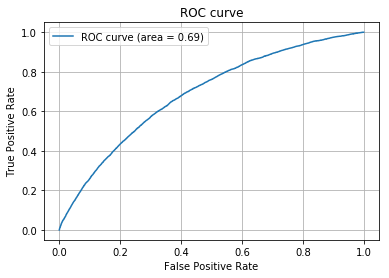

In [23]:
#Lightgbmで実行
lgb_pred= pipeline(X_train, X_test, y_train, 
                           lgb.LGBMClassifier( num_leaves=30, min_data_in_leaf=30))
auc_score(y_test, lgb_pred)

これ以降は欠損値を埋めなくてよいLGBMを使用する。

### ・新しい特徴量を作成

In [24]:
#再度データの読み込み
df = pd.read_csv('drive/My Drive/Sprint1/application_train.csv')

#EXT_SOURCEのみ欠損値を平均で埋める(PolynomialFeaturesのため)
df['EXT_SOURCE_1'].fillna(df['EXT_SOURCE_1'].mean(), inplace=True)
df['EXT_SOURCE_2'].fillna(df['EXT_SOURCE_2'].mean(), inplace=True)
df['EXT_SOURCE_3'].fillna(df['EXT_SOURCE_3'].mean(), inplace=True)

#新しい特徴量を作成し、dfに追加
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['INCOME_CREDIT_PERCENT'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']

#データの絞り込み
df_list = ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'ANNUITY_INCOME_PERCENT',
          'CREDIT_TERM', 'INCOME_CREDIT_PERCENT', 'INCOME_PER_PERSON', 'DAYS_EMPLOYED_PERCENT']

df = df[df_list]
df.head()

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,ANNUITY_INCOME_PERCENT,CREDIT_TERM,INCOME_CREDIT_PERCENT,INCOME_PER_PERSON,DAYS_EMPLOYED_PERCENT
0,1,0.083037,0.262949,0.139376,0.121978,0.060749,0.498036,202500.0,0.067329
1,0,0.311267,0.622246,0.510853,0.132217,0.027598,0.208736,135000.0,0.070862
2,0,0.502130,0.555912,0.729567,0.100000,0.050000,0.500000,67500.0,0.011814
3,0,0.502130,0.650442,0.510853,0.219900,0.094941,0.431748,67500.0,0.159905
4,0,0.502130,0.322738,0.510853,0.179963,0.042623,0.236842,121500.0,0.152418


In [0]:
#データをndrrayに格納
X = df.iloc[:, 1:].values
y = df['TARGET'].values

#データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y)

AUC : 0.7501123217256731


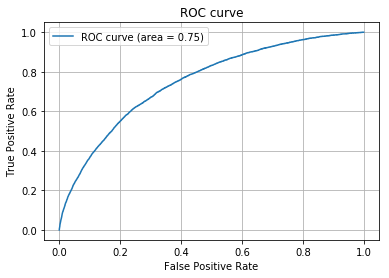

In [26]:
import lightgbm as lgb
lgb = lgb.LGBMClassifier(num_leaves=30,  min_data_in_leaf=30)


lgb.fit(X_train, y_train)

y_pred = lgb.predict_proba(X_test)[:, 1]
auc_score(y_test, y_pred)

### ・特徴量同士をかけ合わせる(PolynomialFeatures)   
EXT_SOURCEを3次までかけ合わせる

In [27]:
#3次までの変数を作成
cubic = PolynomialFeatures(degree = 3)

#fit_transform
X_cubic = cubic.fit_transform(X[:, :3])

#列名を取得
cubic_name = cubic.get_feature_names(df.columns[1:])

#DataFrameにする
df_cubic = pd.DataFrame(X_cubic, columns=cubic_name)
df_cubic.head()

#結合
df_poly3= pd.concat([df, df_cubic.iloc[:, 4:]], axis=1)
df_poly3.head()

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,ANNUITY_INCOME_PERCENT,CREDIT_TERM,INCOME_CREDIT_PERCENT,INCOME_PER_PERSON,DAYS_EMPLOYED_PERCENT,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_2^2,EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_3^2,EXT_SOURCE_1^3,EXT_SOURCE_1^2 EXT_SOURCE_2,EXT_SOURCE_1^2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_2^2,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_3^2,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_3^3
0,1,0.083037,0.262949,0.139376,0.121978,0.060749,0.498036,202500.0,0.067329,0.006895,0.021834,0.011573,0.069142,0.036649,0.019426,0.000573,0.001813,0.000961,0.005741,0.003043,0.001613,0.018181,0.009637,0.005108,0.002707
1,0,0.311267,0.622246,0.510853,0.132217,0.027598,0.208736,135000.0,0.070862,0.096887,0.193685,0.159012,0.387190,0.317876,0.260971,0.030158,0.060288,0.049495,0.120520,0.098944,0.081232,0.240927,0.197797,0.162388,0.133318
2,0,0.502130,0.555912,0.729567,0.100000,0.050000,0.500000,67500.0,0.011814,0.252134,0.279140,0.366337,0.309038,0.405575,0.532268,0.126604,0.140165,0.183949,0.155177,0.203651,0.267267,0.171798,0.225464,0.295894,0.388325
3,0,0.502130,0.650442,0.510853,0.219900,0.094941,0.431748,67500.0,0.159905,0.252134,0.326606,0.256514,0.423074,0.332280,0.260971,0.126604,0.163999,0.128804,0.212438,0.166848,0.131041,0.275185,0.216129,0.169746,0.133318
4,0,0.502130,0.322738,0.510853,0.179963,0.042623,0.236842,121500.0,0.152418,0.252134,0.162057,0.256514,0.104160,0.164872,0.260971,0.126604,0.081373,0.128804,0.052302,0.082787,0.131041,0.033616,0.053210,0.084225,0.133318


In [0]:
#データをndrrayに格納
X_poly3 = df_poly3.iloc[:, 1:].values
y_poly3 = df_poly3['TARGET'].values

#データの分割
X_poly3_train, X_poly3_test, y_poly3_train, y_poly3_test = train_test_split(X_poly3, y_poly3)

AUC : 0.7478664194433117


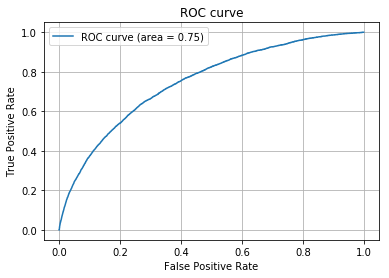

In [30]:
#Lightgbmで3次まで
import lightgbm as lgb
lgb = lgb.LGBMClassifier(num_leaves=30,  min_data_in_leaf=30)

lgb.fit(X_poly3_train, y_poly3_train)

y_poly3_pred = lgb.predict_proba(X_poly3_test)[:, 1]
auc_score(y_poly3_test, y_poly3_pred)

In [32]:
#Lightgbmのグリッドサーチ
#検証パラメータ
import lightgbm as lgb
num_leaves = list(range(20 , 41, 5))
min_data_in_leaf = list(range(15, 31, 3))
lgb_param_grid = {'lgbmclassifier__num_leaves': num_leaves, 
                             'lgbmclassifier__min_data_in_leaf': min_data_in_leaf}

gridserch(X_poly3_train, X_poly3_test, y_poly3_train, y_poly3_test, lgb_param_grid, lgb.LGBMClassifier())

Test set score: 0.7473042806348977
Best parameters: {'lgbmclassifier__min_data_in_leaf': 30, 'lgbmclassifier__num_leaves': 25}
Best cross-validation: 0.7515280233217837


AUC : 0.7485150765970616


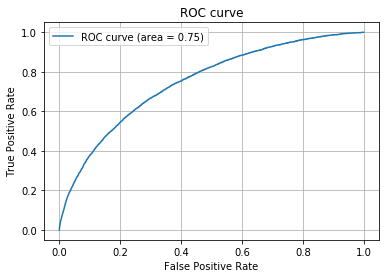

In [33]:
#Lightgbmで3次まで
import lightgbm as lgb
lgb = lgb.LGBMClassifier(num_leaves=25,  min_data_in_leaf=30)


lgb.fit(X_poly3_train, y_poly3_train)

y_poly3_pred = lgb.predict_proba(X_poly3_test)[:, 1]
auc_score(y_poly3_test, y_poly3_pred)

EXT_SOURCEを2次までかけ合わせる

In [34]:
#2次までの変数を作成
quadratic = PolynomialFeatures(degree = 2)

#fit_transform
X_quadratic = quadratic.fit_transform(X[:, :3])

#列名を取得
quadratic_name = quadratic.get_feature_names(df.columns[1:])

#DataFrameにする
df_quadratic = pd.DataFrame(X_quadratic, columns=quadratic_name)

#結合
df_poly2 = pd.concat([df, df_quadratic.iloc[:, 4:]], axis=1)
df_poly2.head()

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,ANNUITY_INCOME_PERCENT,CREDIT_TERM,INCOME_CREDIT_PERCENT,INCOME_PER_PERSON,DAYS_EMPLOYED_PERCENT,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_2^2,EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_3^2
0,1,0.083037,0.262949,0.139376,0.121978,0.060749,0.498036,202500.0,0.067329,0.006895,0.021834,0.011573,0.069142,0.036649,0.019426
1,0,0.311267,0.622246,0.510853,0.132217,0.027598,0.208736,135000.0,0.070862,0.096887,0.193685,0.159012,0.387190,0.317876,0.260971
2,0,0.502130,0.555912,0.729567,0.100000,0.050000,0.500000,67500.0,0.011814,0.252134,0.279140,0.366337,0.309038,0.405575,0.532268
3,0,0.502130,0.650442,0.510853,0.219900,0.094941,0.431748,67500.0,0.159905,0.252134,0.326606,0.256514,0.423074,0.332280,0.260971
4,0,0.502130,0.322738,0.510853,0.179963,0.042623,0.236842,121500.0,0.152418,0.252134,0.162057,0.256514,0.104160,0.164872,0.260971


In [0]:
#データをndrrayに格納
X_poly2 = df_poly2.iloc[:, 1:].values
y_poly2 = df_poly2['TARGET'].values

#データの分割
X_poly2_train, X_poly2_test, y_poly2_train, y_poly2_test = train_test_split(X_poly2, y_poly2)

AUC : 0.7507330381632951


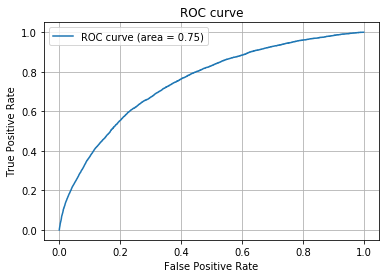

In [37]:
#Lightgbmで2次まで
import lightgbm as lgb
lgb = lgb.LGBMClassifier(num_leaves=30,  min_data_in_leaf=30)


lgb.fit(X_poly2_train, y_poly2_train)

y_poly2_pred = lgb.predict_proba(X_poly2_test)[:, 1]
auc_score(y_poly2_test, y_poly2_pred)

In [38]:
#Lightgbmのグリッドサーチ
#検証パラメータ
import lightgbm as lgb
num_leaves = list(range(20 , 41, 5))
min_data_in_leaf = list(range(15, 31, 3))
lgb_param_grid = {'lgbmclassifier__num_leaves': num_leaves, 
                             'lgbmclassifier__min_data_in_leaf': min_data_in_leaf}

gridserch(X_poly2_train, X_poly2_test, y_poly2_train, y_poly2_test, lgb_param_grid, lgb.LGBMClassifier())

Test set score: 0.7518932228155517
Best parameters: {'lgbmclassifier__min_data_in_leaf': 21, 'lgbmclassifier__num_leaves': 25}
Best cross-validation: 0.7500210501680499


AUC : 0.7517777145043355


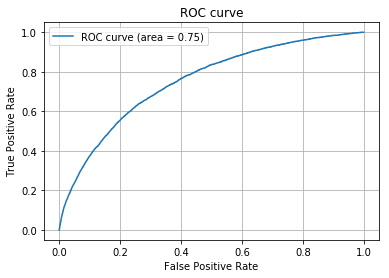

In [39]:
#Lightgbmで2次まで
import lightgbm as lgb
lgb = lgb.LGBMClassifier(num_leaves=25,  min_data_in_leaf=21)


lgb.fit(X_poly2_train, y_poly2_train)

y_poly2_pred = lgb.predict_proba(X_poly2_test)[:, 1]
auc_score(y_poly2_test, y_poly2_pred)

特徴量同士をかけ合わせたことで、スコアが上昇した。今回は2次までかけ合わせたものがスコアが良くなった。
これを用いてsubmissionする。

In [41]:
#テストデータ
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERCENT,ANNUITY_INCOME_PERCENT
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329.0,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.121044,0.152300
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469.0,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0.247398,0.175455
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458.0,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,0.501180,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,0.222477,0.344578
3,100028,Cash 

In [0]:
#テストデータに同様の処理を行う
#EXT_SOURCEのみ欠損値を平均で埋める(PolynomialFeaturesのため)
df_test['EXT_SOURCE_1'].fillna(df_test['EXT_SOURCE_1'].mean(), inplace=True)
df_test['EXT_SOURCE_2'].fillna(df_test['EXT_SOURCE_2'].mean(), inplace=True)
df_test['EXT_SOURCE_3'].fillna(df_test['EXT_SOURCE_3'].mean(), inplace=True)

#新しい特徴量を作成し、dfに追加
df_test['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
df_test['DAYS_EMPLOYED_PERCENT'] = df_test['DAYS_EMPLOYED'] / df_test['DAYS_BIRTH']
df_test['ANNUITY_INCOME_PERCENT'] = df_test['AMT_ANNUITY'] / df_test['AMT_INCOME_TOTAL']
df_test['CREDIT_TERM'] = df_test['AMT_ANNUITY'] / df_test['AMT_CREDIT']
df_test['INCOME_CREDIT_PERCENT'] = df_test['AMT_INCOME_TOTAL'] / df_test['AMT_CREDIT']
df_test['INCOME_PER_PERSON'] = df_test['AMT_INCOME_TOTAL'] / df_test['CNT_FAM_MEMBERS']

#データの絞り込み
df_test_list =  ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'ANNUITY_INCOME_PERCENT',
          'CREDIT_TERM', 'INCOME_CREDIT_PERCENT', 'INCOME_PER_PERSON', 'DAYS_EMPLOYED_PERCENT']
df_test = df_test[df_test_list]

#2次までの変数を作成
poly_test = PolynomialFeatures(degree = 2)

#fit_transform
X_poly_test = poly_test.fit_transform(df_test.iloc[:, :3])

#DataFrameにする
df_poly_test = pd.DataFrame(X_poly_test)

#結合
df_test = pd.concat([df_test, df_poly_test.iloc[:, 4:]], axis=1)

#データをndrrayに格納
test_features = df_test.values

#予測(LGBM)
import lightgbm as lgb
lgb = lgb.LGBMClassifier(num_leaves=25,  min_data_in_leaf=21)
lgb.fit(X_poly2, y_poly2)
test_pred = lgb.predict_proba(test_features)[:, 1]

In [0]:
homecredit_submission = pd.DataFrame({ 'SK_ID_CURR': sk_id,'TARGET': test_pred})
homecredit_submission.to_csv("drive/My Drive/Sprint1/homecredit_submission.csv", index=False)

Private Scoreは0.73725、Public Scoreは0.74559となった。
一応PolynomialFeaturesを3次にしてやってみる。

In [0]:
#テストデータの読み込み
df_test = pd.read_csv('drive/My Drive/Sprint1/application_test.csv')

#テストデータに同様の処理を行う
#EXT_SOURCEのみ欠損値を平均で埋める(PolynomialFeaturesのため)
df_test['EXT_SOURCE_1'].fillna(df_test['EXT_SOURCE_1'].mean(), inplace=True)
df_test['EXT_SOURCE_2'].fillna(df_test['EXT_SOURCE_2'].mean(), inplace=True)
df_test['EXT_SOURCE_3'].fillna(df_test['EXT_SOURCE_3'].mean(), inplace=True)

#新しい特徴量を作成し、dfに追加
df_test['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
df_test['DAYS_EMPLOYED_PERCENT'] = df_test['DAYS_EMPLOYED'] / df_test['DAYS_BIRTH']
df_test['ANNUITY_INCOME_PERCENT'] = df_test['AMT_ANNUITY'] / df_test['AMT_INCOME_TOTAL']
df_test['CREDIT_TERM'] = df_test['AMT_ANNUITY'] / df_test['AMT_CREDIT']
df_test['INCOME_CREDIT_PERCENT'] = df_test['AMT_INCOME_TOTAL'] / df_test['AMT_CREDIT']
df_test['INCOME_PER_PERSON'] = df_test['AMT_INCOME_TOTAL'] / df_test['CNT_FAM_MEMBERS']

#データの絞り込み
df_test_list =  ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'ANNUITY_INCOME_PERCENT',
          'CREDIT_TERM', 'INCOME_CREDIT_PERCENT', 'INCOME_PER_PERSON', 'DAYS_EMPLOYED_PERCENT']
df_test = df_test[df_test_list]

#2次までの変数を作成
poly_test = PolynomialFeatures(degree = 3)

#fit_transform
X_poly_test = poly_test.fit_transform(df_test.iloc[:, :3])

#DataFrameにする
df_poly_test = pd.DataFrame(X_poly_test)

#結合
df_test = pd.concat([df_test, df_poly_test.iloc[:, 4:]], axis=1)

#データをndrrayに格納
test_features = df_test.values

#予測(LGBM)
import lightgbm as lgb
lgb = lgb.LGBMClassifier(num_leaves=25,  min_data_in_leaf=30)
lgb.fit(X_poly3, y_poly3)
test_pred = lgb.predict_proba(test_features)[:, 1]

In [0]:
homecredit_submission = pd.DataFrame({ 'SK_ID_CURR': sk_id,'TARGET': test_pred})
homecredit_submission.to_csv("drive/My Drive/Sprint1/homecredit_submission.csv", index=False)

Private Scoreは0.73695と下がったが、Public Scoreは0.74760と上がった。